## Component objective

Now that we have had a basic understanding of the collected customer population, and some common characteristics that can be employed to segment customers into multiple groups. We would like to all that previously generated results as our newly engineered features to let a machine learning model to learn off of. Furthermore, a simulation for the cost of sending the wrong offers is included to determine under what circumstances, or modeling errors, a trained model would produced the lowest cost for the business.

Upon successful execution of this component, a trained model will be prepared for further predicting that which existing rewards program customers will likely to complete which type of offers next. 

Methodologies to be examined:
- Logistic regression model
- LightGBM classifier
    - Bayesian optimization hyperparameter tuning
    - Learning curve
- Simulations

## Table of contents
1. Data labeling, and final feature preparation
2. Model training
    - Logistic regression modeling as our baseline performance
    - LightGBM classifier modeling as the potential better model
    - Bayesian optimization based hyperparameter tuning
    - Learning curve examination
3. Cost simulation using previously made cost assumptions

## Questions to answer:
1. Should the marketing team send offer to a particular rewards program customer?
2. If so, then which particular offer would help business achieve highest revenue and lowest cost?
3. How does the customer groups labeled as ideal and valuable react to each type of offer?

## 1. Final training data preparation

### 1.1 Data labeling
Strategy:
- To answer the first key questions above, we should rephrase it as "which type of offers (informational, discount or bogo offers), a given customer is most likely to complete". This way, we would be able to construct a multi-class learning objective and train a model of our choice.

Labeling logic:
0. A customer with a "info_or_promo" 0 indicates the following scenarios:
    - This customer has not received any offers at all, hence labeled as unsuccessful.
    - This customer has received informational offers (at least one), but failed to view them. Hence labeled as unsuccessful.
    - This customer has received promotion offers (at least one), but failed to complete them. Hence labeled as unsuccessful.
1. A customer with a "info_or_promo" 1 indicates this customer has received and viewed at least one informational offers.
2. A customer with a "info_or_promo" 2 indicates this customer has received and completed at least one discount offers.
3. A customer with a "info_or_promo" 3 indicates this customer has received and completed at least one bogo offers.

Additional notes:
- For an informational offer, success means viewing the offer; for a promotion offer, success means complete the offer.
- Some customers may receive the same offer multiple times and they may or may not complete all of them. For this case, we only want to count when the customer completes such offer at least once. This is a modeling decision because when customer complete the same offer multiple times, it introduce duplicates to the dataset. And when the customer does not complete all of the same offers they receive, it introduce noise to the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, learning_curve, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, recall_score
from sklearn.linear_model import LogisticRegression
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn import preprocessing
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier, plotting
from imblearn.over_sampling import SMOTE
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

pd.set_option('display.max_columns', None)

In [2]:
path = 'C:/Users/607991/Desktop/Starbucks Capstone/Data/Processed'
profile = pd.read_csv(path+'/profile_processed2.csv')
transcript = pd.read_csv(path+'/transcript_processed.csv')
portfolio = pd.read_csv(path+'/portfolio_processed.csv')

In [3]:
# training data labeling for the first key question

offer_received_df = transcript.query('event == "offer received"')
offer_viewed_df = transcript.query('event == "offer viewed"')
offer_completed_df = transcript.query('event=="offer completed"')

info = ['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837']
bogo = ['ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0','9b98b8c7a33c4b65b9aebfe6a799e6d9',
        'f19421c1d4aa40978ebb69ca19b0e20d']
discount = ['0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2','fafdcd668e3743c1bb461111dcafc2a4',
           '2906b810c7d4411798c6938adc9daaa5']

offer = []
label = []
person = []

# looping through each customer
for each_person in offer_received_df.person.unique().tolist():    

    # for each customer, looping through each unique offer they received
    for each_offer in offer_received_df.query('person == @each_person')['offer_id'].unique().tolist():    
        
        if (each_offer in info) and \
        (each_person in offer_viewed_df.query('offer_id == @each_offer').person.unique().tolist()):        # logic 1
            label.append(1)
            offer.append(each_offer)
            person.append(each_person)
        
        elif (each_offer in discount) and \
        (each_person in offer_completed_df.query('offer_id == @each_offer').person.unique().tolist()):     # logic 2
            label.append(2)
            offer.append(each_offer)
            person.append(each_person)
        
        elif (each_offer in bogo) and \
        (each_person in offer_completed_df.query('offer_id == @each_offer').person.unique().tolist()):     # logic 3
            label.append(3)
            offer.append(each_offer) 
            person.append(each_person)                                                                     
            
        else: 
            label.append(0)
            offer.append(each_offer) 
            person.append(each_person)                                                                     # logic 0

In [4]:
# appending the labels to the profile dataset which is our base dataset

temp = pd.DataFrame(list(zip(person, offer, label)), columns=['person','offer','info_or_promo'])
profile_new = pd.merge(profile.set_index('id'), temp, how='right', left_index=True, right_on='person')

In [5]:
# examine labeling accuracy

display(len(label) == len(person) == len(offer) == len(profile_new))
display(transcript.query('person=="31dda685af34476cad5bc968bdb01c53" and event=="offer received"'))
display(transcript.query('person=="31dda685af34476cad5bc968bdb01c53" and event=="offer completed"'))
display(profile_new.query('person=="31dda685af34476cad5bc968bdb01c53"'))

True

,Unnamed: 0,event,person,time,amount,offer_id,reward
9,9,offer received,31dda685af34476cad5bc968bdb01c53,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
53244,53244,offer received,31dda685af34476cad5bc968bdb01c53,168,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
110837,110837,offer received,31dda685af34476cad5bc968bdb01c53,336,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
150605,150605,offer received,31dda685af34476cad5bc968bdb01c53,408,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
201579,201579,offer received,31dda685af34476cad5bc968bdb01c53,504,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
245130,245130,offer received,31dda685af34476cad5bc968bdb01c53,576,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN


,Unnamed: 0,event,person,time,amount,offer_id,reward
96363,96363,offer completed,31dda685af34476cad5bc968bdb01c53,258,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
143576,143576,offer completed,31dda685af34476cad5bc968bdb01c53,384,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
174359,174359,offer completed,31dda685af34476cad5bc968bdb01c53,426,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0
230415,230415,offer completed,31dda685af34476cad5bc968bdb01c53,534,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0


,age,gender,income,age_group,became_member_year,became_member_month,became_member_day,became_member_weekday,offer_received,offer_viewed,offer_completed,offer_received_viewed_completed,offer_not_received_completed,offer_not_viewed_completed,amount_spent,reward_received,no_purchase,with_purchase,time,recency,r_quartile,f_quartile,m_quartile,rfm_score,rfm_score_sum,rfm_segments,clusters,person,offer,info_or_promo
34,0.44,F,0.455556,60-69,0.6,0.090909,0.333333,0.5,1.0,0.833333,0.666667,0.666667,0.0,0.0,0.099615,0.2,made_purchase,purchased_viewed,0.69863,0.30137,4,1,1,411,0.333333,valuable,1,31dda685af34476cad5bc968bdb01c53,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
35,0.44,F,0.455556,60-69,0.6,0.090909,0.333333,0.5,1.0,0.833333,0.666667,0.666667,0.0,0.0,0.099615,0.2,made_purchase,purchased_viewed,0.69863,0.30137,4,1,1,411,0.333333,valuable,1,31dda685af34476cad5bc968bdb01c53,fafdcd668e3743c1bb461111dcafc2a4,2
36,0.44,F,0.455556,60-69,0.6,0.090909,0.333333,0.5,1.0,0.833333,0.666667,0.666667,0.0,0.0,0.099615,0.2,made_purchase,purchased_viewed,0.69863,0.30137,4,1,1,411,0.333333,valuable,1,31dda685af34476cad5bc968bdb01c53,2298d6c36e964ae4a3e7e9706d1fb8c2,2


- Taking customer "31dda685af34476cad5bc968bdb01c53" as an example, he or she received 6 offers in total, some offers have duplicates. In our resulting dataset, we only want to include 3 of these offers because out of all the offers, there are 3 unique ones.
- This customer did not complete offer "0b1e1539f2cc45b7b9fa7c272da2e1d7", so we will give this register a "0" in the label column. However, this customer did complete discount offers "fafdcd668e3743c1bb461111dcafc2a4" and "2298d6c36e964ae4a3e7e9706d1fb8c2" (multiple times for this one), so we will label these register as "2"s in the label column.

### 1.2 Final Feature preparation

- We drop no_purchase and with_purchase columns because they represent cumulated results that describes individual customers when the profile dataset was based on customer-level (each row vector represent one customer). So if we were to include these columns, then it wouldn't make sense because our label column is based on each purchase register. The no_purchase and with_purchase columns would contain values that are conflicts with the associated labeling values.
- We also need to drop the columns that describe characteristics of each offers because we want to build a model that learn off of customers' characteristics and not to rely on the information about the offers. That said, we will not be joining with the portfolio dataset.
- We keep the rfm_segments and clustering results because we assume that offers will be sending to the customers who are already members of the rewards program with some purchasing history. In other words, we assume that we wouldn't send to those who just joined our program with little or no purchasing history.
    - This decision enables us to replicate the same processing steps (rfm analysis, k-prototype clustering) for the unseen customers and prepare them in a way so that the trained model can utilize. 

In [6]:
# drop unwanted columns

training_df = profile_new.drop(['offer', 'person', 'age_group', 'no_purchase','with_purchase'], axis=1)

# convert certain columns to categorical using cat.code

cat_cols = training_df.drop('info_or_promo', axis=1).select_dtypes(include=['object','uint16','int64']).columns.tolist()

for each in cat_cols:
    training_df[each] = training_df[each].astype('category')
    training_df[each] = training_df[each].cat.codes
    training_df[each] = training_df[each].astype('category')

### 1. Final training data preparation conclusion

Summary:
- The entire first section of this component is designated to define a labeling strategy in which the resulted targets can be utilized by a machine learning model. We decided that the model learning objective would be predictiing multi-class labels. 
    - If a customer receives an informational offer and completed (viewed) it, then this instance would be labeled as class 1.
    - If a customer receives a discount offer and completed it, then this instance would be labeled as class 2.
    - If a customer receives a bogo offer and completed it, then this instance would be labeled as class 3.
    - All else instances are labeled as class 0.
- During the final feature praparation part, we intentionally left out features come from the portfolio dataset. Our goal is to train a model that only relies on customers' characteristics as well as their purchasing history.   
- Please note that results (rfm_score, clusters) from the previous component remains in the final training set. This is because these results are derived from the characteristics of the customers and the analysis can be replicated in the future if we were given a set of unseen customers records to be learned in modeling training. 

## 2. Model training

### 2.1 Determining which type of offers to send (informational, discount or bogo offers)  

In [8]:
# train-test split

train, test = train_test_split(training_df,test_size=0.2,random_state=0)
train, val = train_test_split(train,test_size=0.1,random_state=0)
x_train, x_test, x_val = train.drop('info_or_promo', axis=1), test.drop('info_or_promo', axis=1), val.drop('info_or_promo', axis=1)
y_train, y_test, y_val = train['info_or_promo'], test['info_or_promo'], val['info_or_promo']

y_train.value_counts()

0    18066
2    10993
3     9785
1     6723
Name: info_or_promo, dtype: int64

- We will use the "class_weight" option from the LogisticRegression LGBMClassifier models to counter class imbalance.

In [8]:
# Logistic regression model as our baseline model

lr = LogisticRegression(class_weight='balanced', multi_class='multinomial')
lr.fit(x_train, y_train)

y_pred_base = lr.predict(x_test)
print(confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))

[[3459  861  390  255]
 [ 686  555  337  290]
 [ 430  483 1390  808]
 [ 267  418  689 1340]]
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      4965
           1       0.24      0.30      0.27      1868
           2       0.50      0.45      0.47      3111
           3       0.50      0.49      0.50      2714

    accuracy                           0.53     12658
   macro avg       0.49      0.48      0.48     12658
weighted avg       0.54      0.53      0.54     12658



C:\Users\607991\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


- It's observed that the logistic regression model does not converge. This modeling result certainly is not usable as our baseline. For this reason, I will use the early-stopping option available in lightGBM.

In [9]:
# LGBMClassifier baseline performance

lgb = LGBMClassifier(objective='multiclass', metric='multi_logloss', class_weight='balanced')
feature_name = x_train.columns.tolist()
lgb.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_val, y_val)], eval_metric= 'multi_logloss', 
        early_stopping_rounds=30, feature_name=feature_name, categorical_feature=cat_cols, verbose=50)

y_pred = lgb.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\607991\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['clusters', 'f_quartile', 'gender', 'm_quartile', 'r_quartile', 'rfm_score', 'rfm_segments']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[50]	training's multi_logloss: 0.995605	valid_1's multi_logloss: 0.988739
Early stopping, best iteration is:
[59]	training's multi_logloss: 0.987144	valid_1's multi_logloss: 0.987639
[[3302  531  610  522]
 [ 613  483  359  413]
 [ 261  398 1508  944]
 [ 160  359  608 1587]]
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      4965
           1       0.27      0.26      0.27      1868
           2       0.49      0.48      0.49      3111
           3       0.46      0.58      0.51      2714

    accuracy                           0.54     12658
   macro avg       0.50      0.50      0.49     12658
weighted avg       0.56      0.54      0.55     12658



- Our model reached its best iteration before overfit. The lightGBM model does not perform well too for all class predictions. 
- We can conclude that the current train set does not contain meaningful information that allows a model to rely on in order to make correction predictions. 
- To solve this problem, I will add addtional information, about characteristics of different offers, from the portfolio dataset to the current train sets. Please note, that this move certainly will improve the modeling score, but we also take the risk of information leakage since different types of offers have fix set of channels, difficulty, and duration combinations.
- So, it is my responsibility to find the right balance beween reveal too much information and not including enough of information. For this reason, I will only select the channels feature from the portfolio dataset. 

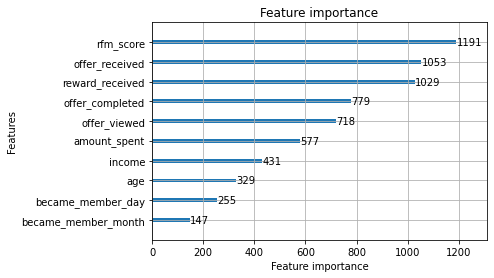

In [10]:
plotting.plot_importance(lgb, max_num_features=10)

- Before moving onto joining the portfolio dataset, let's take a look at feature importance plot. We observe that the current lgb model learns most from rfm_score (our RFM segmentation results), offer_received, and reward_received. 

In [11]:
# join with the portfolio dataset

profile_new_2 = profile_new.set_index('offer').join(portfolio.set_index('id')['channels'])
profile_new_2.columns

Index(['age', 'gender', 'income', 'age_group', 'became_member_year',
       'became_member_month', 'became_member_day', 'became_member_weekday',
       'offer_received', 'offer_viewed', 'offer_completed',
       'offer_received_viewed_completed', 'offer_not_received_completed',
       'offer_not_viewed_completed', 'amount_spent', 'reward_received',
       'no_purchase', 'with_purchase', 'time', 'recency', 'r_quartile',
       'f_quartile', 'm_quartile', 'rfm_score', 'rfm_score_sum',
       'rfm_segments', 'clusters', 'person', 'info_or_promo', 'channels'],
      dtype='object')

In [12]:
# follow the same feature preparation as before

training_df_2 = profile_new_2.drop(['person', 'age_group', 'no_purchase','with_purchase'], axis=1)
cat_cols_2 = training_df_2.drop('info_or_promo', axis=1).select_dtypes(include=['object','uint16','int64']).columns.tolist()

for each in cat_cols_2:
    training_df_2[each] = training_df_2[each].astype('category')
    training_df_2[each] = training_df_2[each].cat.codes
    training_df_2[each] = training_df_2[each].astype('category')

In [13]:
# do another round of train-test split

train_2, test_2 = train_test_split(training_df_2,test_size=0.2,random_state=0)
train_2, val_2 = train_test_split(train_2,test_size=0.1,random_state=0)
x_train_2, x_test_2, x_val_2 = train_2.drop('info_or_promo', axis=1), test_2.drop('info_or_promo', axis=1), val_2.drop('info_or_promo', axis=1)
y_train_2, y_test_2, y_val_2 = train_2['info_or_promo'], test_2['info_or_promo'], val_2['info_or_promo']

In [14]:
# do another round of lgb training using the new train set

lgb_2 = LGBMClassifier(objective='multiclass', metric='multi_logloss', class_weight='balanced')
feature_name = x_train_2.columns.tolist()
lgb_2.fit(x_train_2, y_train_2, eval_set = [(x_train_2, y_train_2), (x_val_2, y_val_2)], 
        eval_metric= 'multi_logloss', early_stopping_rounds=30, feature_name=feature_name, 
        categorical_feature=cat_cols_2, verbose=50)

y_pred_2 = lgb_2.predict(x_test_2)
print(confusion_matrix(y_test_2, y_pred_2))
print(classification_report(y_test_2, y_pred_2))

C:\Users\607991\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['channels', 'clusters', 'f_quartile', 'gender', 'm_quartile', 'r_quartile', 'rfm_score', 'rfm_segments']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[50]	training's multi_logloss: 0.678037	valid_1's multi_logloss: 0.726407
[100]	training's multi_logloss: 0.634372	valid_1's multi_logloss: 0.714433
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 0.634372	valid_1's multi_logloss: 0.714433
[[2640 1109  775  494]
 [ 115 1445   39  246]
 [  69  212 2174  652]
 [ 115  426  555 1592]]
              precision    recall  f1-score   support

           0       0.90      0.53      0.66      5018
           1       0.45      0.78      0.57      1845
           2       0.61      0.70      0.65      3107
           3       0.53      0.59      0.56      2688

    accuracy                           0.62     12658
   macro avg       0.62      0.65      0.61     12658
weighted avg       0.69      0.62      0.63     12658



- It's observed that the modeling score, in terms of weighted avg f1, has been improved from 0.55 to 0.63.
- Including the new feature "channels" from the portfolio dataset is the maximum level of tolerance I have towards training features. Next, I will tune the model and use its learning curve to determine whether the model has reached its potential.

### 2.2 Model improvements - Bayesian optimization based parameter tuning

In [15]:
# defining parameter search space

lgb_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 800, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 100, 1)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 20.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 20.0),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 100, 1)),
    }

In [18]:
# Bayesian optimization based model parameter tuning

def hyperopt(estimator, param_space, X_train, y_train, X_test, y_test, num_eval, objective=None, eval_metric=None, 
             fit_metric=None, class_weight=None):
    
    start = time.time()
    def objective_function(params):
        model = estimator(**params, objective=objective, class_weight=class_weight)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring=eval_metric).mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    
    loss = [x['result']['loss'] for x in trials.trials]
    feature_name = X_train.columns.tolist()
    cat_cols = X_train.select_dtypes(include='category').columns.tolist()
    
    
    if str(estimator) == "<class 'lightgbm.sklearn.LGBMClassifier'>":
        
        for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
            best_param[each] = int(best_param[each])
        
        model_best = estimator(**best_param, objective=objective, class_weight=class_weight)     
        model_best.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric= fit_metric, 
                       early_stopping_rounds=30, feature_name=feature_name, categorical_feature=cat_cols_2, verbose=100)
        y_pred = model_best.predict(X_test)
    
    
    print("")
    print("##### Results #####")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", f1_score(y_test, y_pred, average='weighted'))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    
    return trials

In [19]:
# hyperparameter tuning

num_eval=30
eval_metric = 'f1_weighted'
class_weight = 'balanced'
objective = 'multiclass'
fit_metric = 'multi_logloss'

lgb_hyperopt = hyperopt(LGBMClassifier, lgb_space, x_train_2, y_train_2, x_val_2, y_val_2, num_eval, objective, 
                        eval_metric, fit_metric, class_weight)

100%|██████████████████████████████████████████████████| 30/30 [13:11<00:00, 26.38s/it, best loss: -0.6308399599445543]
Training until validation scores don't improve for 30 rounds

C:\Users\607991\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['channels', 'clusters', 'f_quartile', 'gender', 'm_quartile', 'r_quartile', 'rfm_score', 'rfm_segments']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[100]	training's multi_logloss: 0.899249	valid_1's multi_logloss: 0.91948
[200]	training's multi_logloss: 0.762402	valid_1's multi_logloss: 0.797495
Did not meet early stopping. Best iteration is:
[287]	training's multi_logloss: 0.710297	valid_1's multi_logloss: 0.755336

##### Results #####
Score best parameters:  0.6308399599445543
Best parameters:  {'bagging_fraction': 0.7915826310397323, 'colsample_by_tree': 0.7022779271309514, 'learning_rate': 0.012570946395584776, 'max_depth': 18, 'min_child_samples': 54, 'n_estimators': 287, 'num_leaves': 44, 'reg_alpha': 1.2330346362844646, 'reg_lambda': 14.052899848887177}
Test Score:  0.626379371477563
Time elapsed:  797.4922697544098
Parameter combinations evaluated:  30


In [20]:
# unpack the best parameters selected

unpack_function = lambda l: [item for sublist in l for item in sublist]
unpack_all = lgb_hyperopt.best_trial['misc']['vals']
unpack_values = [i for i in unpack_all.values()]
values = unpack_function(unpack_values)
keys = [i for i in unpack_all.keys()]
best_param = {keys[i]: values[i] for i in range(len(keys))} 

for each in ['num_leaves','max_depth','n_estimators','min_child_samples']:
    best_param[each] = int(best_param[each])

In [21]:
lgb_final = LGBMClassifier(objective='multiclass', metric='multi_logloss', class_weight='balanced', **best_param)
feature_name = x_train_2.columns.tolist()
lgb_final.fit(x_train_2, y_train_2, eval_set = [(x_train_2, y_train_2), (x_val_2, y_val_2)], eval_metric= 'multi_logloss', 
        early_stopping_rounds=30, feature_name=feature_name, categorical_feature=cat_cols_2, verbose=100)

y_pred_final = lgb_final.predict(x_test_2)
print(confusion_matrix(y_test_2, y_pred_final))
print(classification_report(y_test_2, y_pred_final))

C:\Users\607991\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['channels', 'clusters', 'f_quartile', 'gender', 'm_quartile', 'r_quartile', 'rfm_score', 'rfm_segments']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.899249	valid_1's multi_logloss: 0.91948
[200]	training's multi_logloss: 0.762402	valid_1's multi_logloss: 0.797495
Did not meet early stopping. Best iteration is:
[287]	training's multi_logloss: 0.710297	valid_1's multi_logloss: 0.755336
[[2594 1143  791  490]
 [ 120 1456   35  234]
 [  54  211 2177  665]
 [  86  417  503 1682]]
              precision    recall  f1-score   support

           0       0.91      0.52      0.66      5018
           1       0.45      0.79      0.57      1845
           2       0.62      0.70      0.66      3107
           3       0.55      0.63      0.58      2688

    accuracy                           0.62     12658
   macro avg       0.63      0.66      0.62     12658
weighted avg       0.69      0.62      0.63     12658



- Hyperparameter did not improve model's performance. This indicates that there is a fix amount of information can be learned by the model and that information mainly comes from the channels column

### 2.3 Modeling performance assessment

In [22]:
# learning curve

def learning_curve_graph(model, x, y, scorer, tune_params, tune_result, title, x_label, y_label, 
                         objective=None, metric=None, class_weight=None):
    
    # Initialize a learning curve figure

    fig, axes = plt.subplots(1, 1, figsize=(8, 7))
    axes.set_title(title)
    axes.set_ylim(tune_result[0], tune_result[1])
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)

    # learning curve calculations

    cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    train_sizes, train_scores, test_scores = \
    learning_curve(model(**tune_params, objective=objective, metric=metric, class_weight=class_weight), 
                   x, y, scoring=scorer,
                   cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the curve

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")
    axes.legend(loc="best")

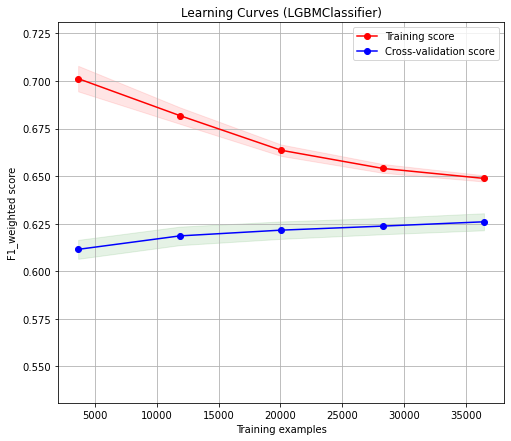

In [23]:
objective='multiclass'
metric='multi_logloss'
class_weight='balanced'
result_range = [(lgb_hyperopt.best_trial['result']['loss']*-1)-0.1, (lgb_hyperopt.best_trial['result']['loss']*-1)+0.1]
title = "Learning Curves (LGBMClassifier)"
x_label = "Training examples"
y_label = "F1_weighted score"

learning_curve_graph(LGBMClassifier, x_train_2, y_train_2, 'f1_weighted', best_param, result_range, title, x_label, y_label,
                    objective, metric, class_weight)

- We observe that when the trainig size is small, the gap test learning curve and train learning curve is large. This is expected as the model could just memorize all the answers given that there are only a few training samples. 
- However, as the training size became larger and larger, the gap between train learning curve and test learning curve narrows down. This trend indicates that the model became more and more stable as more training samples are introduced. In addition, there is no sign of overfitting, and it is very likely that the training error and test error came across at around 0.63.

### 2. Model training conclusion
Summary:
- A logistic regression model, with class_weight option set as balanced, was first trained to establish baseline model performance, in terms of f1-weighted score. We observe that its test score was 0.54 which is almost equivalent to a dummy classifier.
- Next, a lightGBM classifier was trained, and we observe that there is no performance gain even if lightGBM is considered as a potentially better learner in many cases. This result prompt us to further include more information from the portfolio dataset, namely the channels feature. 
- Please note that the portfolio dataset contains information that describes each offer's nature, and our modeling objective is to predict which type of offers (information, bogo, or discount) a given customer would most certainly complete. So if we were adding to much information from the portfolio dataset, we would have high risk of information leakage. The maximum level of tollerance towards adding in new features, would be only allowing the channels feature to be added to the training set.
- As a result, a trained lightGBM classifier improves its test f1 weighted score to 0.63. But we also observe that there is no potential value presides in other features that describe customer characteristics. 

Conclusion:
- We conclude that a trained lightGBM classifier model eventually will achieve 0.63 as the final testing f1 weighted score. This score has been improved from 0.55 when the channels column was not included. Since we only added the channels column as an extra feature and no sign of improvements are observed during parameter tuning, we conclude that the testing score improvements is mainly caused by the channels column, and there is only a fixed amount of information that a model can learn off of. This conclusion can be proven by observing from model's curve.
- This scoring result is rather poor and it implies that the model should not be used in production until either more meaningful features are added or data labeling logics are refined.

## 3. Cost simulation

Original plan:

Now that the first key question (which type of offers to send) is answered, we can move onto the second key question, "which particular offer would help business achieve highest revenue and lowest cost?". A common approach to solve this problem would be starting from a train model and analyze its error rates such as recall, and precision. By adjusting the probability threshold (only applicable in a binary problem), we would be able to observe how recall and precisions behaves accordingly. Then by applying the cost assumptions to various recall/precision, we would be able to obtain a cost function that allows us to determine at what probability threshold and recall/precision level, the cost of modeling errors could be minimized. 

New plan:

However, since our modeling objective is mul-class prediction by design, the concept of adjusting the probability threshold will not be applicable in our case. Thus, I purposely choose to do a cost simulation instead of a cost analysis. The machanism that drives the simulation is that by adjusting predicted probabilities of each class, we would obtain various level of simulated modeling error rates for which we could then apply to the cost assumptions. As a result, different cost will be shown in addition to their associated error rates and other modeling performance metrics. We would then be able to pick a cost that's acceptable. In the subsequent model improvement works, we can aim to achieve that observed modeling performance, knowing that the cost would be minized as a result of this.

New question to answer:

Because of the decision made above, I will rephrase the second question which is stated in the begining of this analysis. Thus, instead of answering "which particular offer would help business achieve highest revenue and lowest cost?", I will use the following cost simulation to answer "given the current state of the model, what improvements can be made in regards to modeling performance for each class label, to achieve a minimized cost after applying the cost assumptions?".

Additional note:
- It's because predicted class probabilities are the main driver for various level of prevision and recall, we choose it as the sole input of the simulator function.
- The current model performance is rather poor. This is another reason I decided to do simulations because it represents hypothetical cases to show a minimized cost that can be potentially achieved if model performance is improved to a certain level.

### Cost assumptions

- Based on the entire customer population, which is unknown to us, the percentage of rewards program members who remain to be in-active (at-risk) is about 26.448%.
- The bogo and discount offers cost the same, \\$1600 dollars per customer (one-time).
- If a potentially interested customer is lost then it will cost the business \\$11500 dollars per customer (one-time).
- The bogo and discount offers are assumed to be 45% effective on average. That is 45% of the rewards program members who are identified as potential participants and they have received the bogo and discount offers, actually decide to participate and make purchasing decisions. The remaining 55% will not participate anyway.

In [36]:
# predicted class probability simulator

def probability_simulator(empty_list, y_true_prob, y_true, col_index):
    
    for each in np.linspace(y_true_prob[col_index].mean(), 0.99, 10):

        mu, sigma = each, y_true_prob[col_index].std()
        s = np.random.normal(mu, sigma, 12658)

        class_prob_simulated = s[s<1]
        class_prob_simulated = pd.DataFrame(resample(class_prob_simulated, replace=True, 
                                                     n_samples=12658, random_state=123), columns=[col_index])
        y_true_prob[col_index] = class_prob_simulated
        y_pred_simulated = y_true_prob.idxmax(axis=1)
        cnf_matrix = confusion_matrix(y_true, y_pred_simulated)

        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)

        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)

        # true positive rate
        TPR = TP/(TP+FN)
        # true negative rate
        TNR = TN/(TN+FP) 
        # positive predictive value
        PPV = TP/(TP+FP)
        # negative predictive value
        NPV = TN/(TN+FN)
        # false positive rate
        FPR = FP/(FP+TN)
        # false negative rate
        FNR = FN/(TP+FN)
        # false discovery rate
        FDR = FP/(TP+FP)
        # overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        empty_list.append([mu, sigma, TPR[col_index], TNR[col_index], PPV[col_index], NPV[col_index], FPR[col_index], 
                        FNR[col_index], FDR[col_index], ACC[col_index]])

    empty_list.append(['class1_prob_mean', 'class1_prob_std', 'tpr','tnr','ppv','npv','fpr','fnr','fdr','overall_accuracy'])
    column_names = empty_list.pop(10)
    df = pd.DataFrame(empty_list, columns=column_names)
    
    return df

# cost function

def cost_simulator(df):
    for i in range(len(df)):
        df.loc[i,'expected_cost'] = (1-0.26448)*df.loc[i,'fpr']*1600 + \
        0.26448*df.loc[i,'fnr']*11500 + \
        0.26448*df.loc[i,'tpr']*1600*0.45 + \
        (1600+11500)*0.55*0.26448*df.loc[i,'tpr']
    display(df)
    
    return df

In [33]:
# cost simulations for class 1 predictions

y_prob = pd.DataFrame(lgb_final.predict_proba(x_test_2))
temp = []
class1_simulation_results = probability_simulator(temp, y_prob, y_test_2, 1)
class1_simulation_results = cost_simulator(class1_simulation_results)

,class1_prob_mean,class1_prob_std,tpr,tnr,ppv,npv,fpr,fnr,fdr,overall_accuracy,expected_cost
0,0.214289,0.250789,0.372358,0.869139,0.326832,0.890299,0.130861,0.627642,0.673168,0.796729,2843.451228
1,0.300480,0.248649,0.497561,0.806252,0.304680,0.903888,0.193748,0.502439,0.695320,0.761258,2799.077296
2,0.386670,0.245498,0.621680,0.728198,0.280715,0.918572,0.271802,0.378320,0.719285,0.712672,2773.577241
3,0.472860,0.240031,0.727913,0.644872,0.259116,0.932843,0.355128,0.272087,0.740884,0.656976,2771.192444
4,0.559050,0.227986,0.805962,0.554055,0.235695,0.943613,0.445945,0.194038,0.764305,0.590773,2804.271966
5,0.645240,0.215213,0.886179,0.455100,0.217218,0.959072,0.544900,0.113821,0.782782,0.517933,2844.879061
6,0.731430,0.196827,0.944173,0.357533,0.200483,0.974049,0.642467,0.055827,0.799517,0.443040,2904.865100
7,0.817620,0.169806,0.983198,0.266069,0.186051,0.989340,0.733931,0.016802,0.813949,0.370596,2975.604651
8,0.903810,0.135958,0.991328,0.199297,0.174406,0.992630,0.800703,0.008672,0.825594,0.314742,3046.496342
9,0.990000,0.099891,0.999458,0.128641,0.163678,0.999282,0.871359,0.000542,0.836322,0.255570,3121.959100


- The final lightGBM classifer after tuned has a class 1 recall rate at 0.79. We observe from the simulation results, an optimal cost is achieved when class 1 recall rate is at 0.72. At first, this observation might seem contradicting to what our goal would be, which is to improve recall rate for all class predictions. 
- However, this observation can be interpreted as a potentially better model could sacrifice its performance in class 1 predictions in order for it to gain performance in other class predictions. This is a business decision to be made.
- As the simulated results suggest, a recall at 0.72 would achieve an expected cost of \\$2771 dollars per customer.

In [34]:
# cost simulations for class 2 predictions

y_prob = pd.DataFrame(lgb_final.predict_proba(x_test_2))
temp = []
class2_simulation_results = probability_simulator(temp, y_prob, y_test_2, 2)
class2_simulation_results = cost_simulator(class2_simulation_results)

,class1_prob_mean,class1_prob_std,tpr,tnr,ppv,npv,fpr,fnr,fdr,overall_accuracy,expected_cost
0,0.251786,0.266093,0.408754,0.851848,0.472998,0.815803,0.148152,0.591246,0.527002,0.743087,2829.386196
1,0.333810,0.262135,0.514322,0.799916,0.455400,0.835064,0.200084,0.485678,0.544600,0.729815,2790.684822
2,0.415834,0.255603,0.614741,0.729034,0.424633,0.853309,0.270966,0.385259,0.575367,0.700980,2779.154556
3,0.497857,0.246860,0.723206,0.642969,0.397207,0.877160,0.357031,0.276794,0.602793,0.662664,2777.882599
4,0.579881,0.233567,0.795945,0.549052,0.364749,0.892140,0.450948,0.204055,0.635251,0.609654,2819.631108
5,0.661905,0.216419,0.893145,0.460580,0.350069,0.929825,0.539420,0.106855,0.649931,0.566756,2831.844239
6,0.743929,0.190274,0.959125,0.361114,0.328122,0.964485,0.638886,0.040875,0.671878,0.507900,2886.513851
7,0.825952,0.161465,0.983585,0.266569,0.303747,0.980362,0.733431,0.016415,0.696253,0.442566,2974.649352
8,0.907976,0.130330,0.997425,0.182389,0.284103,0.995429,0.817611,0.002575,0.715897,0.382446,3060.629004
9,0.990000,0.095030,1.000000,0.122814,0.270527,1.000000,0.877186,0.000000,0.729473,0.338126,3128.304125


- As the simulated results show, an optimal cost is achieved when the recall for class 2 predictions is at 0.72. 
- Our final model's recall, for class 2 predictions, is 0.70. So we interpret this as the current final model is already at its optimal state in regards to class 2 predicitons. 
- Using the stated cost assumption, it is reasonable to conclude that our final model has a expected cost of \\$2777 per customer. 

In [35]:
# cost simulations for class 3 predictions

y_prob = pd.DataFrame(lgb_final.predict_proba(x_test_2))
temp = []
class3_simulation_results = probability_simulator(temp, y_prob, y_test_2, 3)
class3_simulation_results = cost_simulator(class3_simulation_results)

,class1_prob_mean,class1_prob_std,tpr,tnr,ppv,npv,fpr,fnr,fdr,overall_accuracy,expected_cost
0,0.227124,0.227268,0.307292,0.904814,0.465352,0.828907,0.095186,0.692708,0.534648,0.777927,2862.988222
1,0.311888,0.225584,0.398810,0.841825,0.404681,0.838545,0.158175,0.601190,0.595319,0.747748,2850.584055
2,0.396652,0.224507,0.528646,0.770110,0.382709,0.858357,0.229890,0.471354,0.617291,0.718834,2812.218425
3,0.481416,0.222630,0.658482,0.698997,0.370991,0.883606,0.301003,0.341518,0.629009,0.690393,2773.144571
4,0.566180,0.216452,0.777158,0.605015,0.346607,0.909667,0.394985,0.222842,0.653393,0.641571,2771.535859
5,0.650944,0.203672,0.861979,0.501805,0.318094,0.930964,0.498195,0.138021,0.681906,0.578290,2812.796235
6,0.735708,0.184863,0.937872,0.398696,0.296031,0.959681,0.601304,0.062128,0.703969,0.513193,2862.380681
7,0.820472,0.160236,0.979167,0.303310,0.274796,0.981818,0.696690,0.020833,0.725204,0.446832,2935.589419
8,0.905236,0.130555,0.997768,0.214042,0.254991,0.997196,0.785958,0.002232,0.745009,0.380471,3023.054903
9,0.990000,0.096694,1.000000,0.133701,0.237351,1.000000,0.866299,0.000000,0.762649,0.317665,3115.492263


- Our final currently has a recall of 0.60 for class 3 predictions. However, as the simulation results suggest, modeling performance for class 3 predictions would our priority in the next iterations of modeling improvement works. 
- If we were able to achieve 0.77 for the class 3 recall, then the minized expected cost would be achieved at \\$2771 dollars per customer. 

### 3. Cost simulation conclusion

- Our current final model has a weighted avg f1 score of 0.63. By conducting simulations of various probabilities for each class, we were able to conclude that the area that future improvements is most needed is class 3 results. Specifically, we would like to achieve a 0.77 for class 3 recall. 

At the end of component 2 conclusion, I left a question unanswered, which is "How does the customer groups labeled as ideal and valuable react to each type of offer?". Now that we have joined the processed profile dataset (with RFM segment results appended) with the processed transcript dataset, I will answer this question first before moving onto the component 3 conclusion.

In [67]:
profile_new.groupby('rfm_segments').agg(lambda x:x.value_counts().index[0])[['gender','age_group','rfm_score','clusters',
                                                                             'offer','info_or_promo']]

,gender,age_group,rfm_score,clusters,offer,info_or_promo
rfm_segments,,,,,,
ideal,F,50-59,111,1,fafdcd668e3743c1bb461111dcafc2a4,2
need_to_reach_out,M,50-59,344,3,3f207df678b143eea3cee63160fa8bed,0
not_spending_enough,M,50-59,444,3,3f207df678b143eea3cee63160fa8bed,0
valuable,M,50-59,311,1,fafdcd668e3743c1bb461111dcafc2a4,2


In [65]:
display(profile_new.groupby('rfm_segments').info_or_promo.value_counts())
display(profile_new.groupby('rfm_segments').gender.value_counts())
display(profile_new.groupby('rfm_segments').clusters.value_counts())
display(profile_new.groupby('rfm_segments').offer.value_counts())

rfm_segments         info_or_promo
ideal                2                 3839
                     3                 3503
                     1                  909
                     0                  564
need_to_reach_out    0                16307
                     1                 4503
                     2                 4016
                     3                 3177
not_spending_enough  0                 4548
                     1                  755
                     2                  128
                     3                  119
valuable             2                 7426
                     3                 6788
                     0                 3564
                     1                 3142
Name: info_or_promo, dtype: int64

rfm_segments         gender
ideal                F          4506
                     M          4173
                     O           126
need_to_reach_out    M         14465
                     F          7429
                     O           281
not_spending_enough  M          2677
                     F          1050
                     O            50
valuable             M         10330
                     F          9823
                     O           312
Name: gender, dtype: int64

rfm_segments         clusters
ideal                1            6647
                     2            2154
                     0              14
need_to_reach_out    3           14859
                     0            6459
                     2            4189
                     1            2496
not_spending_enough  3            3685
                     0            1833
                     2              32
valuable             1           12289
                     2            7233
                     3             894
                     0             504
Name: clusters, dtype: int64

rfm_segments         offer                           
ideal                fafdcd668e3743c1bb461111dcafc2a4    1089
                     2298d6c36e964ae4a3e7e9706d1fb8c2    1002
                     ae264e3637204a6fb9bb56bc8210ddfd     967
                     f19421c1d4aa40978ebb69ca19b0e20d     936
                     0b1e1539f2cc45b7b9fa7c272da2e1d7     929
                     2906b810c7d4411798c6938adc9daaa5     908
                     9b98b8c7a33c4b65b9aebfe6a799e6d9     907
                     4d5c57ea9a6940dd891ad53e9dbe8da0     872
                     3f207df678b143eea3cee63160fa8bed     611
                     5a8bc65990b245e5a138643cd4eb9837     594
need_to_reach_out    3f207df678b143eea3cee63160fa8bed    3132
                     5a8bc65990b245e5a138643cd4eb9837    3094
                     0b1e1539f2cc45b7b9fa7c272da2e1d7    2835
                     4d5c57ea9a6940dd891ad53e9dbe8da0    2797
                     ae264e3637204a6fb9bb56bc8210ddfd    2777
                

"Ideal" customer group:
- The most popular offers are "fafdcd668e3743c1bb461111dcafc2a4" (discount) and "2298d6c36e964ae4a3e7e9706d1fb8c2" (discount).
- The most popular offer type is "discount".
- The most common cluster is "1".
- About half of the customers are female and the other half are male.


"Valuable" customer group:
- The most popular offers are "fafdcd668e3743c1bb461111dcafc2a4" (discount) and "2298d6c36e964ae4a3e7e9706d1fb8c2" (discount).
- The most popular offer type is "discount"
- The most common cluster is "1".
- About half of the customers are female and the other half are male.

## Component conclusion

Questions to answer:
1. How does the customer groups labeled as ideal and valuable react to each type of offer?
2. Should the marketing team send offer to a particular rewards program customer?
3. Given the current state of the model, what improvements can be made in regards to modeling performance for each class label, to achieve a minimized cost after applying the cost assumptions?

Findings:
- Discount offers are the most popular ones among customers who are labeled as "ideal" and "valuable". In addition, the same groups of customers most likely come from cluster 1.
- To answer the second question, our original intent was to train/tune a machine learning model and let it predict which offer types a given customer would most likely to complete. Then the business could plan ahead using these prediction results. However, even after taking the risk of information leakage by adding the "channels" column, our final model still produces inferior results. 
- Based on this condition and the learning objective (multi-class) of our model, I switched from conducting a cost analysis to a cost simulation, in order to answer question 3. As a result, we found the area that future improvements is most needed is class 3 results. Specifically, we would like to achieve a 0.77 for class 3 recall in order to minimize the cost, given all other class predictions does not change.